In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn		   #继承nn.Module构建rnn网络	
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader #构建迭代器

In [61]:
# 读取数据
train_power_forecast_history = pd.read_csv('./训练集/power_forecast_history.csv')
train_power = pd.read_csv('./训练集/power.csv')
train_stub_info = pd.read_csv('./训练集/stub_info.csv')

test_power_forecast_history = pd.read_csv('./测试集/power_forecast_history.csv')
test_stub_info = pd.read_csv('./测试集/stub_info.csv')

In [62]:
# Group by id_encode and ds, and then sum the power for each group
daily_power = train_power.groupby(['id_encode', 'ds']).agg({'power': 'sum'}).reset_index()

# Display the first few rows of the aggregated data
daily_power.head()

,id_encode,ds,power
0,0,20220415,2288.2240
1,0,20220416,2398.5730
2,0,20220417,2313.0330
3,0,20220418,2095.3259
4,0,20220419,1834.3590


In [63]:
# Pivot the table to have columns as station IDs and rows as dates with values being the power consumption
power_pivot = daily_power.pivot(index='ds', columns='id_encode', values='power')

# Display the first few rows of the pivoted data
power_pivot.head()

id_encode,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
ds,,,,,,,,,,,,,,,,,,,,,
20220415,2288.2240,0.00,975.8800,0.000,58.19,46.3640,129.7160,1179.2560,NaN,NaN,...,NaN,79.4739,NaN,930.5170,425.7301,155.6049,41.234,1005.4800,140.2560,429.62
20220416,2398.5730,15.19,990.9201,0.000,29.64,146.5830,72.0510,1155.9400,NaN,NaN,...,NaN,63.4779,NaN,889.6370,323.9110,134.4972,117.931,1084.2782,151.9600,472.86
20220417,2313.0330,2.82,861.7302,39.452,14.21,100.2861,163.0330,985.5572,NaN,NaN,...,NaN,68.9596,NaN,999.1160,550.2170,142.7392,46.000,1232.0159,72.8810,290.35
20220418,2095.3259,42.56,592.7900,0.000,52.80,88.1400,121.0229,1279.2351,NaN,NaN,...,NaN,78.3207,NaN,746.7738,150.5590,89.9431,68.643,791.5701,183.2551,406.04
20220419,1834.3590,20.94,675.4401,103.637,0.00,90.0250,16.8720,1133.4570,NaN,NaN,...,NaN,67.7045,NaN,1119.8079,378.6241,136.7522,44.035,1231.2672,97.8940,364.84


In [64]:
power_pivot_reset = power_pivot.reset_index(drop=True)

power_pivot_reset.head()

id_encode,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,2288.2240,0.00,975.8800,0.000,58.19,46.3640,129.7160,1179.2560,NaN,NaN,...,NaN,79.4739,NaN,930.5170,425.7301,155.6049,41.234,1005.4800,140.2560,429.62
1,2398.5730,15.19,990.9201,0.000,29.64,146.5830,72.0510,1155.9400,NaN,NaN,...,NaN,63.4779,NaN,889.6370,323.9110,134.4972,117.931,1084.2782,151.9600,472.86
2,2313.0330,2.82,861.7302,39.452,14.21,100.2861,163.0330,985.5572,NaN,NaN,...,NaN,68.9596,NaN,999.1160,550.2170,142.7392,46.000,1232.0159,72.8810,290.35
3,2095.3259,42.56,592.7900,0.000,52.80,88.1400,121.0229,1279.2351,NaN,NaN,...,NaN,78.3207,NaN,746.7738,150.5590,89.9431,68.643,791.5701,183.2551,406.04
4,1834.3590,20.94,675.4401,103.637,0.00,90.0250,16.8720,1133.4570,NaN,NaN,...,NaN,67.7045,NaN,1119.8079,378.6241,136.7522,44.035,1231.2672,97.8940,364.84


In [72]:
# Fill NaN values with 0
power_pivot_reset = power_pivot_reset.fillna(0)

# Check if there are any NaN values left
nan_check = power_pivot_reset.isnull().sum().sum()
nan_check


0

In [114]:
# Split the data into training and validation sets
train_data = power_pivot_reset.iloc[:-50,1]
val_data = power_pivot_reset.iloc[-50:,1]

train_data.shape, val_data.shape

((315,), (50,))

In [83]:
train_data.iloc[100:105]

100    2621.4040
101    2726.5150
102    2506.6500
103    2917.6829
104    3086.4740
Name: 0, dtype: float64

In [75]:
train_data.iloc[105:106]

id_encode,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
105,2947.6361,0.0,895.82,223.9481,133.08,190.307,92.8441,2857.772,0.0,0.0,...,0.0,110.8135,0.0,2993.4861,829.0929,288.3232,121.234,2096.9028,163.4548,1073.5999


In [86]:
# 以闭市价作为股价构成标签
price=train_data
#归一化处理，便于后期加速模型收敛
price_norm=price/price.max()
price_norm.head()

0    0.699002
1    0.732711
2    0.706581
3    0.640076
4    0.560356
Name: 0, dtype: float64

In [91]:
#定义etract_data函数，能够将数据转换为时间序列
def etract_data(data, time_step):
    X,y = [],[]
    for i in range(len(data) - time_step):
        X.append(data.iloc[i:i + time_step].values)
        y.append(data.iloc[i + time_step])
    X = torch.tensor(X).float()
    X = X.reshape(-1, time_step, 1)
    y = torch.tensor(y).float()
    y = y.reshape(-1,1)
    return X, y

#时间序列时间步长为8，通过前8个数据预测第9个
time_step = 8
batch_size = 1
X,y=etract_data(price_norm,time_step)

In [92]:
X.shape,y.shape

(torch.Size([307, 8, 1]), torch.Size([307, 1]))

In [115]:
import torch
def process_data(type):
    #读入数据
    if type=='train':
        data=train_data
    elif type=='val':
        data=val_data

    # 以闭市价作为股价构成标签
    price=data
    #归一化处理，便于后期加速模型收敛
    price_norm=price/price.max()

    #定义etract_data函数，能够将数据转换为时间序列
    def etract_data(data, time_step):
        X,y = [],[]
        for i in range(len(data) - time_step):
            X.append(data.iloc[i:i + time_step].values)
            y.append(data.iloc[i + time_step])
        X = torch.tensor(X).float()
        X = X.reshape(-1, time_step, 1)
        y = torch.tensor(y).float()
        y = y.reshape(-1,1)
        return X, y

    #时间序列时间步长为8，通过前8个数据预测第9个
    time_step = 14
    batch_size = 1
    X,y=etract_data(price_norm,time_step)

    #构造迭代器，返回
    dataset=TensorDataset(X,y)
    #训练集数据随机打乱，验证集保持不变
    if type=='train':
        shuffle=True
    else:
        shuffle=False
    dataloader=DataLoader(dataset,batch_size=batch_size,shuffle=shuffle)
    return dataloader
dataloader={'train':process_data('train'),'val':process_data('val')}

In [116]:
#设计网络(单隐藏层Rnn)
input_size,hidden_size,output_size=1,256,1
#Rnn初始隐藏单元hidden_prev初始化
hidden_prev=torch.zeros(1,1,hidden_size).cuda()
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.rnn=nn.RNN(
            input_size=input_size,    #输入特征维度,当前特征为股价，维度为1
            hidden_size=hidden_size,  #隐藏层神经元个数，或者也叫输出的维度
            num_layers=1,
            batch_first=True
        )
        self.linear=nn.Linear(hidden_size,output_size)

    def forward(self,X,hidden_prev):
        out,ht=self.rnn(X,hidden_prev)  
        #out[batch_size=1,time_step=8,hidden_size=20]
        #ht[num_layer=1,batch_size=1,hidden_size=20]
        ht=ht.view(-1,hidden_size)      #ht[1,hidden_size=20]
        ht=self.linear(ht)              #ht[1,1]
        return out,ht

In [117]:
model=Net()
model=model.cuda()
criterion=nn.MSELoss()
learning_rate,epochs=0.01,500
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

best_loss=9999
for epoch in range(epochs):
    for phase in ['train','val']:
        if phase == 'train':
            model.train()
        elif phase == 'val':
            model.eval()

        losses = []
        for X,y in dataloader[phase]:
            X = X.cuda()
            y = y.cuda()
            optimizer.zero_grad()
            _,yy=model(X,hidden_prev)
            yy=yy.cuda()

            loss = criterion(y, yy)
            model.zero_grad()

            if phase=='train':
                loss.backward()
                optimizer.step()

            losses.append(loss.item())

        epoch_loss=sum(losses)/len(losses)

        if phase=='val' and epoch_loss<best_loss:
            best_loss=epoch_loss
            torch.save(model.state_dict(), "model.pth")

        if epoch%50==0:   #保留验证集损失最小的模型参数
            print("epoch:{},{} loss:{:.8f}".format(epoch+1,phase,epoch_loss))
            if phase=='val':
                print("the best loss of valuation is:{:.8f}".format(best_loss))
                print('*'*50)


epoch:1,train loss:0.29090593
epoch:1,val loss:0.25242504
the best loss of valuation is:0.25242504
**************************************************
epoch:51,train loss:0.14585464
epoch:51,val loss:0.41412109
the best loss of valuation is:0.03615164
**************************************************
epoch:101,train loss:0.14527121
epoch:101,val loss:0.05067763
the best loss of valuation is:0.03615164
**************************************************
epoch:151,train loss:0.13819615
epoch:151,val loss:0.04567057
the best loss of valuation is:0.03609549
**************************************************
epoch:201,train loss:0.14693826
epoch:201,val loss:0.45527733
the best loss of valuation is:0.03609549
**************************************************
epoch:251,train loss:0.15544213
epoch:251,val loss:0.11132855
the best loss of valuation is:0.03609549
**************************************************
epoch:301,train loss:0.23419115
epoch:301,val loss:0.03651254
the best loss of val

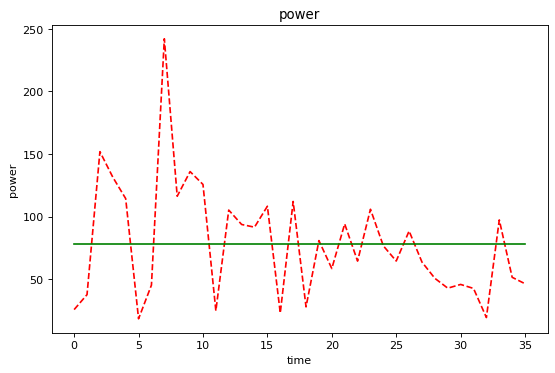

In [118]:
model.load_state_dict(torch.load('model.pth'))
Val_y,Val_predict=[],[]
#将归一化后的数据还原
Val_max_price=max(val_data)
for X,y in dataloader['val']:
    with torch.no_grad():
        X = X.cuda()
        _,predict=model(X,hidden_prev)
        y=y.cpu()
        predict=predict.cpu()
        Val_y.append(y[0][0]*Val_max_price)
        Val_predict.append(predict[0][0]*Val_max_price)

fig=plt.figure(figsize=(8,5),dpi=80)
# 红色表示真实值，绿色表示预测值
plt.plot(Val_y,linestyle='--',color='r')
plt.plot(Val_predict,color='g')
plt.title('power')
plt.xlabel('time')
plt.ylabel('power')
plt.show()

In [128]:
Val_y_tensor = torch.tensor(Val_y)
Val_predict_tensor = torch.tensor(Val_predict)

# Compute the Mean Squared Error (MSE)
mse = torch.nn.functional.mse_loss(Val_y_tensor, Val_predict_tensor)

rmse = torch.sqrt(mse)

print(rmse.item())

45.971256256103516


In [125]:
Val_y,Val_predict

([tensor(25.7360),
  tensor(37.6700),
  tensor(151.8390),
  tensor(131.4650),
  tensor(114.3820),
  tensor(18.3940),
  tensor(45.2770),
  tensor(241.9691),
  tensor(116.2411),
  tensor(135.9259),
  tensor(125.6510),
  tensor(24.7930),
  tensor(105.1879),
  tensor(93.6911),
  tensor(91.5340),
  tensor(108.2569),
  tensor(22.9971),
  tensor(112.0609),
  tensor(27.9050),
  tensor(80.8160),
  tensor(58.4951),
  tensor(94.1360),
  tensor(64.4480),
  tensor(105.8313),
  tensor(76.6341),
  tensor(64.5080),
  tensor(88.4520),
  tensor(63.6520),
  tensor(50.6800),
  tensor(42.8410),
  tensor(45.8110),
  tensor(42.6240),
  tensor(19.3899),
  tensor(97.3230),
  tensor(51.5100),
  tensor(46.3700)],
 [tensor(78.2731),
  tensor(78.2731),
  tensor(78.2731),
  tensor(78.2731),
  tensor(78.2731),
  tensor(78.2731),
  tensor(78.2731),
  tensor(78.2731),
  tensor(78.2731),
  tensor(78.2731),
  tensor(78.2731),
  tensor(78.2731),
  tensor(78.2731),
  tensor(78.2731),
  tensor(78.2731),
  tensor(78.2731),


In [33]:
# Reset the index of the pivoted dataframe
power_pivot_reset = power_pivot.reset_index()

# Display the first few rows of the dataframe with index reset
power_pivot_reset.head()

id_encode,ds,0,1,2,3,4,5,6,7,8,...,490,491,492,493,494,495,496,497,498,499
0,2022-04-15,2288.2240,0.00,975.8800,0.000,58.19,46.3640,129.7160,1179.2560,NaN,...,NaN,79.4739,NaN,930.5170,425.7301,155.6049,41.234,1005.4800,140.2560,429.62
1,2022-04-16,2398.5730,15.19,990.9201,0.000,29.64,146.5830,72.0510,1155.9400,NaN,...,NaN,63.4779,NaN,889.6370,323.9110,134.4972,117.931,1084.2782,151.9600,472.86
2,2022-04-17,2313.0330,2.82,861.7302,39.452,14.21,100.2861,163.0330,985.5572,NaN,...,NaN,68.9596,NaN,999.1160,550.2170,142.7392,46.000,1232.0159,72.8810,290.35
3,2022-04-18,2095.3259,42.56,592.7900,0.000,52.80,88.1400,121.0229,1279.2351,NaN,...,NaN,78.3207,NaN,746.7738,150.5590,89.9431,68.643,791.5701,183.2551,406.04
4,2022-04-19,1834.3590,20.94,675.4401,103.637,0.00,90.0250,16.8720,1133.4570,NaN,...,NaN,67.7045,NaN,1119.8079,378.6241,136.7522,44.035,1231.2672,97.8940,364.84


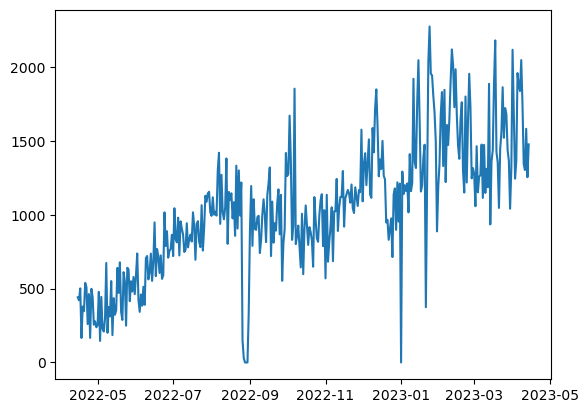

In [31]:
plt.plot(power_pivot.iloc[:,12])

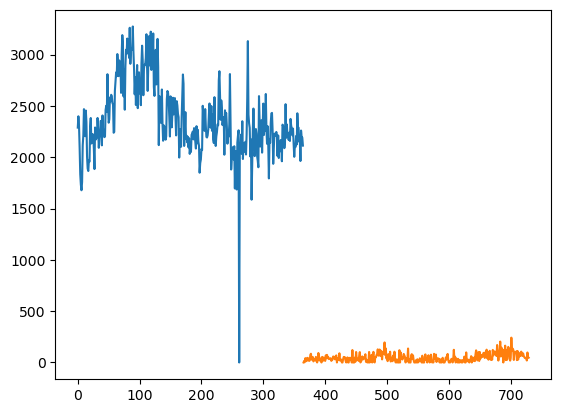

In [14]:
power=daily_power[daily_power['id_encode']==0]['power']
plt.plot(power)
power=daily_power[daily_power['id_encode']==1]['power']
plt.plot(power)

C:\Users\zyz\AppData\Local\Temp\ipykernel_9776\1266109030.py:14: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


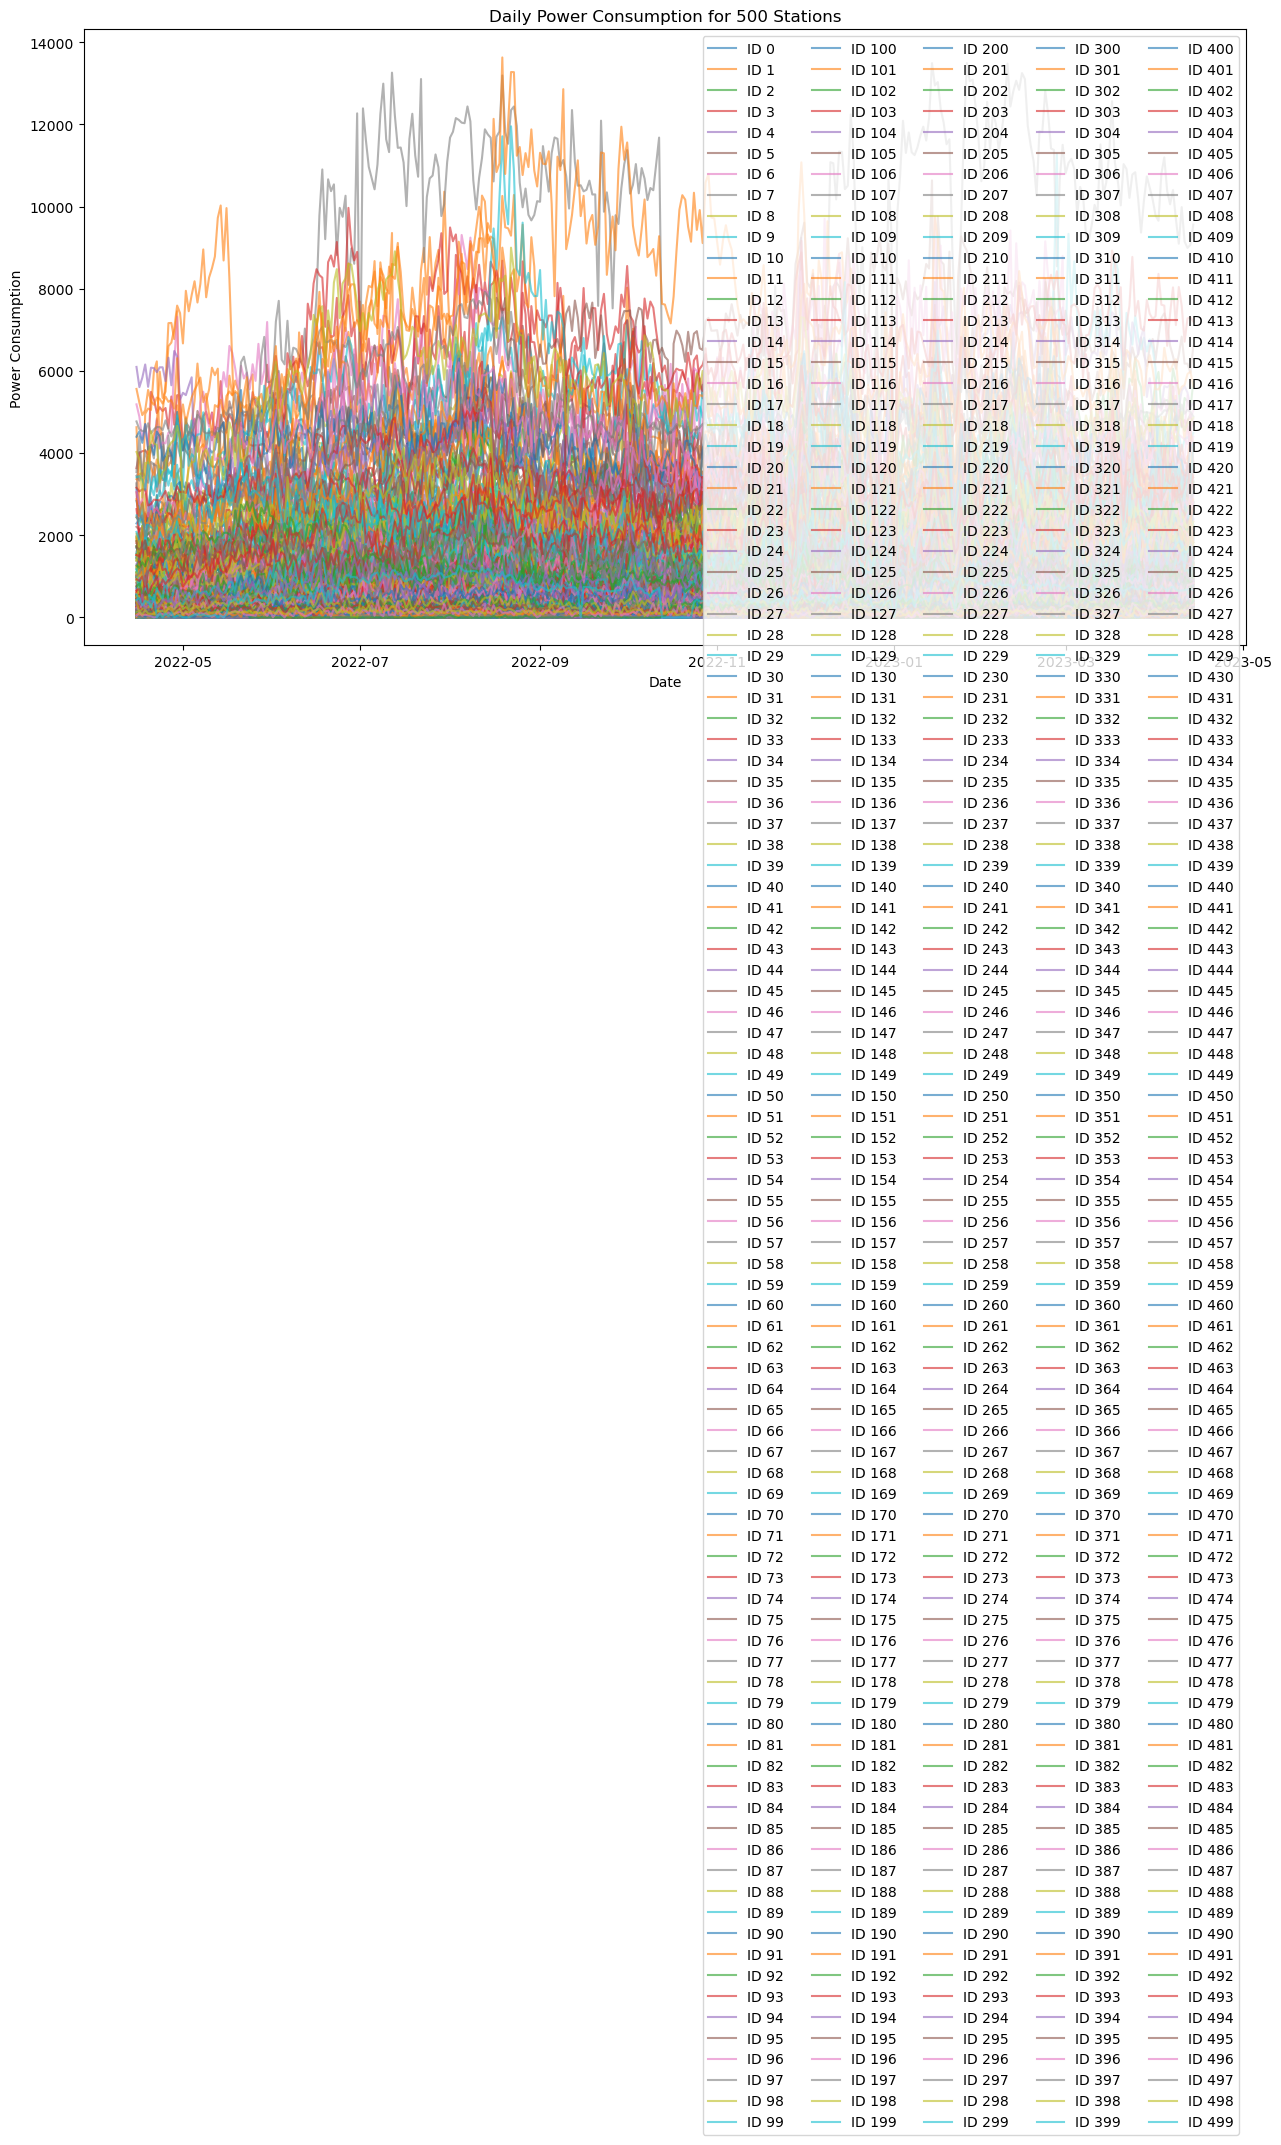

In [19]:
# Convert 'ds' column to datetime format for better plotting
daily_power['ds'] = pd.to_datetime(daily_power['ds'], format='%Y%m%d')

# Plotting
plt.figure(figsize=(15, 8))
for station_id in daily_power['id_encode'].unique():
    subset = daily_power[daily_power['id_encode'] == station_id]
    plt.plot(subset['ds'], subset['power'], label=f"ID {station_id}", alpha=0.6)

plt.title("Daily Power Consumption for 500 Stations")
plt.xlabel("Date")
plt.ylabel("Power Consumption")
plt.legend(loc="upper right", ncol=5)  # Display a few legends to avoid clutter
plt.tight_layout()
plt.show()